In [15]:
import pandas as pd 
import numpy as np 
import scanpy as sc
import matplotlib.pyplot as plt
import concurrent.futures
import pickle
import warnings
from datetime import date
import hisepy
import os
import re
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed,ProcessPoolExecutor
from tqdm import tqdm
import anndata
import gc
from sklearn.mixture import GaussianMixture
warnings.filterwarnings("ignore")
sc.settings.n_jobs = 60
print("Current working directory:", os.getcwd())

Current working directory: /home/jupyter/BRI_Figures_Final_V2/Figure5/03_CD27neg_Effector_B_subtype


In [16]:
# 1) https://stackoverflow.com/questions/26784164/pandas-multiprocessing-apply
# 2) https://stackoverflow.com/questions/5442910/how-to-use-multiprocessing-pool-map-with-multiple-arguments
from multiprocessing import Pool
from itertools import repeat
from functools import partial

# 3) https://stackoverflow.com/questions/817087/call-a-function-with-argument-list-in-python
def mywrapper(func, args): 
    return func(*args)

def parallelize_row_args(df, df_func, args=[], num_of_processes=8):
    ''' Adapted code found in resource #1 with starmap for arguments (resource #2)
    
    Params
    ------
    df pandas.DataFrame
        A dataframe object we wish to parallelize row operations on
    df_func function
        A function that takes a dataframe as the first argument

    '''
    # Set up processes and split data
    data_split = np.array_split(df, num_of_processes)
    pool = Pool(num_of_processes)
    
    # Run fun on each split
    if args is None or len(args) == 0:
        data = pd.concat(pool.map(df_func, data_split))
    else:
        # Set up argument list for each split process if additional args
        arglist = [data_split]
        arglist.extend([repeat(x) for x in args])
        data = pd.concat(pool.starmap(df_func, mywrapper(zip, arglist)))
    
    # Shut down pool
    pool.close()
    pool.join()
    
    return data


In [17]:
ig_genes = ['IGHG1','IGHG2','IGHG3','IGHG4','IGHA1','IGHA2','IGHM','IGHD','IGHE']

In [18]:
def count_pos(df, ig_genes = ig_genes):
    res = df.apply(lambda x: sum(x[ig_genes]), axis = 1)
    return res

def concat_pos(df, ig_genes = ig_genes):
    res = df.apply(lambda x: ";".join([g for g in ig_genes if x[g] is True]), axis = 1)
    return res

def get_is_ig(df, ig, other_ig):
    res = df.apply(lambda x: x[ig] and not any(x[other_ig]), axis = 1)
    return res

def get_is_nonswitched(df, nonswitched, switched):
    res = df.apply(lambda x: any(x[nonswitched]) and not any(x[switched]), axis = 1)
    return res


def determine_isotype(df, gene_order_arr, pos_str_col = 'concat_pos', verbose = True):
    x = df.copy()
    res = ["undetermined" for x in range(df.shape[0])]
    
    for gene in gene_order_arr:
        if not isinstance(gene, str):
            bool_arr = [pd.notna(df[pos_str_col].str.extract('('+g+')')[0]) for g in gene]
            i = 1
            pat_found = bool_arr[0]
            while i < len(bool_arr):
                pat_found = np.logical_and(pat_found, bool_arr[i])
                i+=1
            gene = ";".join(gene)
        else:
            pat_found = pd.notna(x[pos_str_col].str.extract('('+gene+')')[0])
        
        pat_found = np.logical_and(pat_found, [x == 'undetermined' for x in res])
        n_found = len([x for x in pat_found if x is True])
        if verbose:
            print("{} matches for gene {}".format(n_found, gene))
        
        if n_found > 0:
            ifound = [i for i in range(len(pat_found)) if pat_found[i] == True]
            for ichange in ifound:
                res[ichange] = gene
    return res

def classify_ig_df(
    df,
    key = 'barcodes',
    ig_cutoffs = {
       'IGHG1':1,
       'IGHG2':1,
       'IGHG3':1,
       'IGHG4':1,
       'IGHA1':1,
       'IGHA2':1,
       'IGHM':1,
       'IGHD':1,
       'IGHE':1
    },
    switched = ['IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHA1', 'IGHA2','IGHE'],
    nonswitched = ['IGHM', 'IGHD'],
    gene_order_arr = [["IGHM","IGHD"], "IGHM","IGHD","IGHG3","IGHG1","IGHA1","IGHG2","IGHG4","IGHE","IGHA2"],
    keep_normcounts = True,
    num_of_processes = 8,
    verbose = True
):
    
    ''' Classify Ig status for wide dataframe of Ig Norm Counts

    Cells are labeled with switched isotypes a single switched isotype is above (gte) threshold and all other 
    isotypes are less than threshold. Cells are labeled with nonswitched isotypes when all switched isotypes are
    below threshold and one or more nonswitched isotype is above threshold.
    
    Algorithm developed with input from Ziyuan He and Marla Glass. Thresholds may be dataset specific but
    defaults were applied in normalized counts from a 3' scRNA dataset (ALTRA)

    Params
    ------
    df: pandas DataFrame of normalized ig counts
        Dataframe with rows as cells and columns as featres, eg as extracted from an AnnData object 
        using sc.get.obs_df(). Must contain a key column (e.g. barcodes) in addition to columns for
        all ig_genes.
    key: str, default 'barcodes'
        Column in df that is the unique row key
    ig_cutoffs: dict
        Dictionary with names as ig genes and values as cutoff values in the same units (eg normalized counts) 
        as Ig values in df. 
    switched: list, default ['IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHA1', 'IGHA2','IGHE'],
    nonswitched: list, default ['IGHM', 'IGHD'],
    keep_normcounts: bool, default True
        If True the original counts in df will be retained in output. 
    verbose: bool, default True
    
    
    '''
    ig_genes = switched.copy()
    ig_genes.extend(nonswitched)
    
    missing_keys = [x for x in ig_genes if x not in ig_cutoffs.keys()]
    if len(missing_keys) > 0:
        raise KeyError("Missing ig cuttoffs for the following: {}".format(", ".join(missing_keys)))
    
    if key not in df.columns:
        raise KeyError("Missing key column '{}' in data frame".format(key))
                                                                           
    if verbose:
        print("Binarizing Ig detection based on cutoffs")
    bool_df = pd.DataFrame({x: df[x]>= ig_cutoffs[x] for x in ig_genes})
    newcols = [x+"_pos" for x in ig_genes]
    bool_df['n_pos'] =  parallelize_row_args(bool_df, count_pos, args = [ig_genes], num_of_processes= num_of_processes)
    bool_df['concat_pos'] =  parallelize_row_args(bool_df, concat_pos, args = [ig_genes], num_of_processes= num_of_processes)
    bool_df['switched_status'] = 'undetermined'
    
    # Determine switch status
    if verbose:
        print("Determining switched status")
    # array of logical subarrays. one subarray per nonswitched gene. bool values for whether cell was pos for gene
    bool_arr = [pd.notna(bool_df.concat_pos.str.extract('('+g+')')[0]) for g in nonswitched]
    is_nonswitched = bool_arr[0]
    i = 1
    while i < len(bool_arr):
        is_nonswitched = np.logical_or(is_nonswitched, bool_arr[i])
        i+=1
    i_nonswitched = bool_df.index[is_nonswitched]
    bool_df.loc[i_nonswitched, 'switched_status'] = 'nonswitched'
    is_switched = np.logical_and(np.logical_not(is_nonswitched), bool_df.concat_pos != '')
    iswitched = bool_df.index[is_switched]
    bool_df.loc[iswitched, 'switched_status'] = 'switched'

    
    # predict isotype
    if verbose:
        print("Predicting isotypes")
    bool_df['isotype'] = determine_isotype(bool_df, gene_order_arr = gene_order_arr, pos_str_col = 'concat_pos', verbose = True)

    # Format for output
    bool_df.rename(columns={ig_genes[i]: newcols[i] for i in range(len(ig_genes))}, inplace=True)

    keep_cols = [key]
    if keep_normcounts is True:
        keep_cols.extend(ig_genes)
        
    res = pd.concat([df[keep_cols], bool_df], axis=1)
        
    return res

# Read MetaData

In [5]:
meta_data=pd.read_csv("/home/jupyter/BRI_Figures_Final_V2/Figure5/01_Frequency_Comparison/selected_samples_with_acutal_flu_year.csv")

# Assemble Data

In [6]:
meta_data_subset=meta_data[meta_data['Flu_Year'].isin(['2020-2021','2021-2022'])]
meta_data_subset=meta_data_subset[meta_data_subset['sample.visitName'].isin(['Flu Year 1 Day 0','Flu Year 2 Day 0'])]

In [7]:
meta_data_subset=meta_data_subset[meta_data_subset['Covid_exclusion']=='no']

In [8]:
%%time
file_names= ['/home/jupyter/BRI_Figures_Final_V2/Dataset/scRNA/BRI/h5ad/sample_h5ad/'+x+".h5ad" for x in meta_data_subset['pbmc_sample_id'].tolist()]
adata_list = []
with ThreadPoolExecutor(max_workers=30) as executor:
    future_to_file = {executor.submit(sc.read_h5ad, file_name): file_name for file_name in file_names}
    for future in tqdm(as_completed(future_to_file), total=len(file_names)):
        result = future.result()
        if result is not None:
            adata_list.append(result)

100% 136/136 [04:06<00:00,  1.81s/it]

CPU times: user 21.8 s, sys: 27.7 s, total: 49.4 s
Wall time: 4min 7s


In [9]:
adata = anndata.concat(adata_list)
del adata_list 
gc.collect()

0

# Subset CD27- effector B cell

In [10]:
adata_subset=adata[adata.obs['AIFI_L3']=="CD27- effector B cell"]

In [11]:
# re-save raw and re-normalize

sc.pp.normalize_total(adata_subset, target_sum=10000)
adata_subset.layers['X_norm'] = adata_subset.X.copy()
sc.pp.log1p(adata_subset)
adata_subset.layers['X_norm_log1p'] = adata_subset.X.copy()
sc.pp.scale(adata_subset)
adata_subset.layers['X_scale'] = adata_subset.X.copy()


# extract key marker data
keepcols = adata_subset.obs.columns.tolist()
keepcols.extend(ig_genes)

In [12]:
df = sc.get.obs_df(adata_subset, keys = keepcols, layer='X_norm')

In [35]:
%%time
ig_types = classify_ig_df(
    df, 
    key = 'barcodes',
    ig_cutoffs = {
       'IGHG1':0.5,
       'IGHG2':0.5,
       'IGHG3':0.5,
       'IGHG4':0.5,
       'IGHA1':0.5,
       'IGHA2':0.5,
       'IGHM':0.5,
       'IGHD':0.5,
       'IGHE':0.5
    }
)

Binarizing Ig detection based on cutoffs
Determining switched status
Predicting isotypes
3845 matches for gene IGHM;IGHD
628 matches for gene IGHM
81 matches for gene IGHD
577 matches for gene IGHG3
270 matches for gene IGHG1
187 matches for gene IGHA1
18 matches for gene IGHG2
8 matches for gene IGHG4
0 matches for gene IGHE
4 matches for gene IGHA2
CPU times: user 654 ms, sys: 3.04 s, total: 3.7 s
Wall time: 4.61 s


In [36]:
ig_types.switched_status.value_counts()

switched_status
nonswitched     4554
switched        1064
undetermined      15
Name: count, dtype: int64

In [52]:
adata_subset=adata[adata.obs['AIFI_L3']=="CD27- effector B cell"]

In [53]:
adata_subset.raw=adata_subset

In [58]:
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

In [55]:
%%time
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]
sc.pp.scale(adata_subset)
sc.tl.pca(adata_subset, svd_solver='arpack')
sc.pp.neighbors(adata_subset, n_neighbors=20,use_rep='X_pca',n_pcs=5)
sc.tl.umap(adata_subset,min_dist=0.45,random_state=0)

  0%|          | 0/500 [00:00<?, ?it/s]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
CPU times: user 32.8 s, sys: 32.6 s, total: 1min 5s
Wall time: 10.3 s


In [56]:
adata_subset.obs['switched_status']=ig_types.switched_status

In [57]:
adata_subset=adata_subset.raw.to_adata()

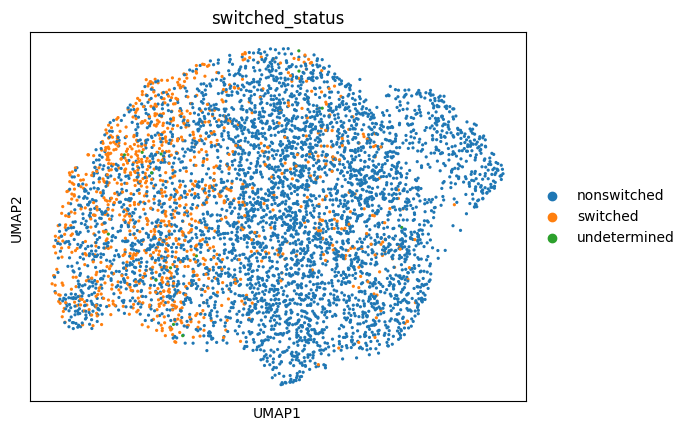

In [59]:
sc.pl.umap(adata_subset, color='switched_status')

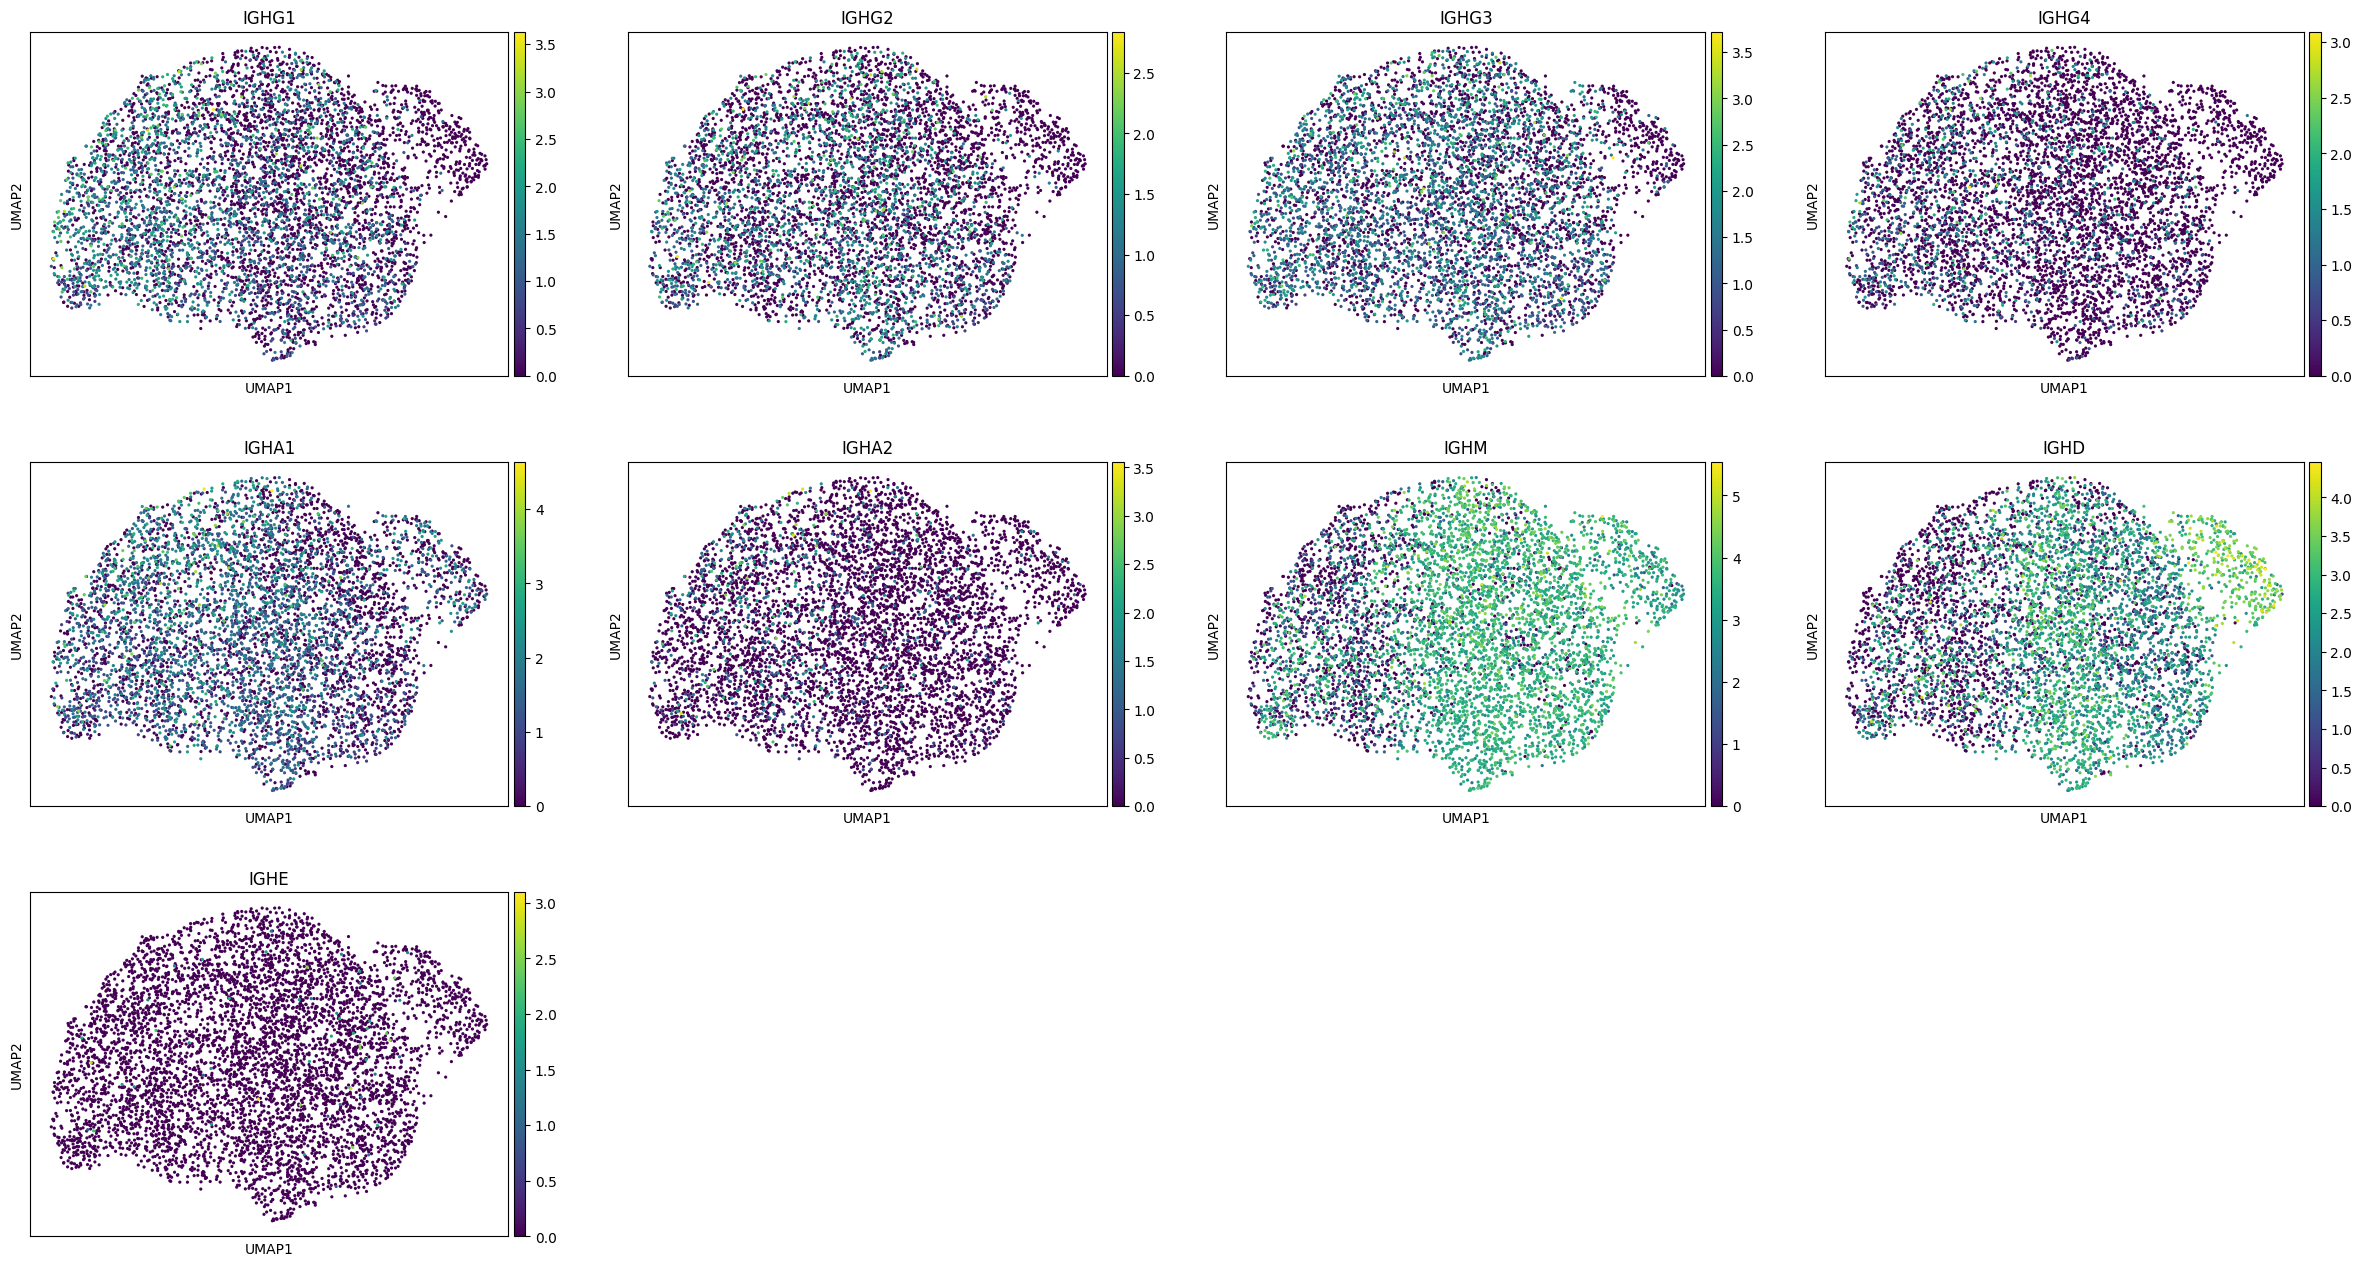

In [60]:
sc.pl.umap(adata_subset, color=ig_genes)

In [42]:
ig_genes

AnnData object with n_obs × n_vars = 5633 × 2315
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid', 'switched_status'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'switched_status_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [43]:
pd.DataFrame(adata_subset.obs[["specimen.specimenGuid",'switched_status','cohort.cohortGuid','sample.sampleKitGuid', 'subject.subjectGuid']].value_counts()).reset_index().to_csv("CD27neg_effector_B_subtype.csv")